# V471TAU

## 2D search of orbital parameters


In [2]:
lev_p = (-0.0070,-0.0000)
lev_v = (34.6, 35.2)

### DATA IN 2004  

In [11]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager
P.style.use(['seaborn-white', 'seaborn-paper', 'seaborn-ticks'])
matplotlib.rc("font", family="Times New Roman", size=12)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

cmap = cm.cm.deep_r

#Define the number of sigmas that you want to consider 
nsigma=11.

# Read file with informations in each run
k, p, v, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_orb_2D_2014.txt', unpack=True)


# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_14.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

# Set global min of spot coverage
vmin = sp_ph.min()
sp_ph /= vmin
print(vmin)

#Set levels for plotting
lev = [1. + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [1. + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(chisq <= 1.0005, test <= 0.005)
k = k[ic]; p = p[ic]; v = v[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= (1. + cut_sigma**2*3.53/count))
k = k[isp]; p = p[isp]; v = v[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(p), N.unique(v))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == p[i], y == v[i])
    m_z[indx] = sp_ph[i]
    m_test[indx] = test[i]

mask = m_z > (1. + cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

print(' Number of points in the fit: ', p.shape[0])
print('\n The lowest spot in the data was at:')
print('P = ', p[sp_ph.argmin()], 'V = ', v[sp_ph.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*p**2 + x[1]*p + x[2]*v**2 + x[3]*v \
                            + x[4]*p*v + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*p**2 + b*p + c*v**2 + d*v + e*p*v + f - sp_ph


print('Position of the center on this plane:')
print(r'P = %.3f and V = %.3f' %(best_x, best_y))
print('dP = %.3f and dV = %1.3f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Spot = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params


0.1663944
 Number of points in the fit:  19

 The lowest spot in the data was at:
P =  -0.0025 V =  34.9
Position of the center on this plane:
P = -0.003 and V = 34.875
dP = 0.000 and dV = 0.012

 Min Spot from fit:
Min Spot =  0.9981797199976086
RMS =  0.0015689181123978465
RMS x dchisq = 19.640126213982086


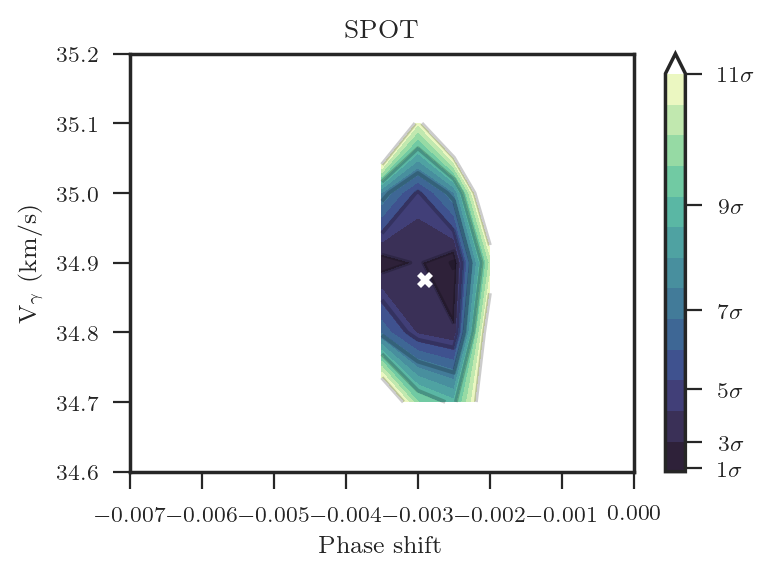

In [12]:

fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True, dpi=100)
cmap.set_over('white')
ax.set_title('SPOT')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14,endpoint=True), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
# Add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_p); ax.set_ylim(lev_v)
ax.plot(best_x, best_y, 'X', color='w')
ax.set_xlabel(r'Phase shift')
ax.set_ylabel(r'V$_\gamma$ (km/s)')
P.tight_layout()
P.show()